ObservationSetup(freqs=<Quantity [ 700.        ,  768.42105263,  836.84210526,  905.26315789,
            973.68421053, 1042.10526316, 1110.52631579, 1178.94736842,
           1247.36842105, 1315.78947368, 1384.21052632, 1452.63157895,
           1521.05263158, 1589.47368421, 1657.89473684, 1726.31578947,
           1794.73684211, 1863.15789474, 1931.57894737, 2000.        ] MHz>, antennas=<EarthLocation [(-2409499.15825597, -4477843.17866913, 3839278.25356749),
                (-2408948.29126895, -4476819.4406148 , 3840807.19874531),
                (-2407752.62132085, -4478122.76917865, 3840042.63784291),
                (-2408303.3795277 , -4479146.30163312, 3838513.51939715),
                (-2410049.80481076, -4478866.50706947, 3837748.96185334),
                (-2411245.47342669, -4477563.17947134, 3838513.51939715),
                (-2410694.71809189, -4476539.64547144, 3840042.63784291),
                (-2408397.20389838, -4475795.29299694, 3842335.79724605),
               

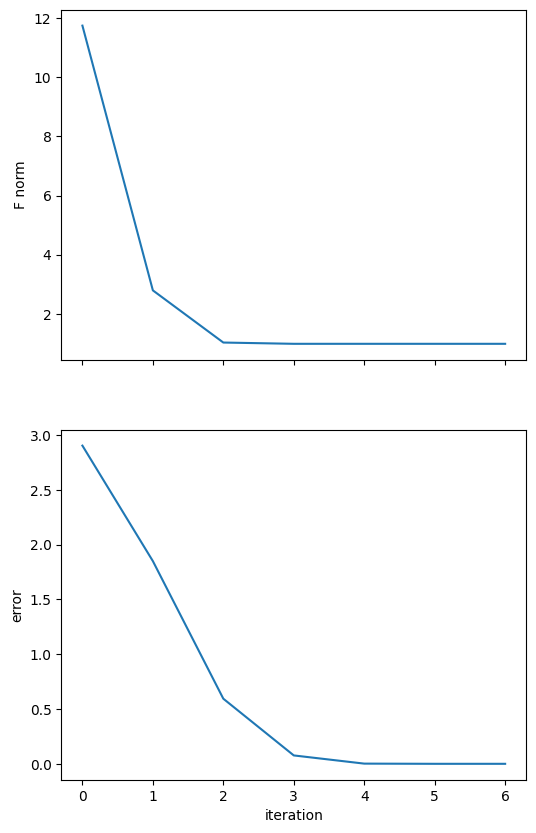

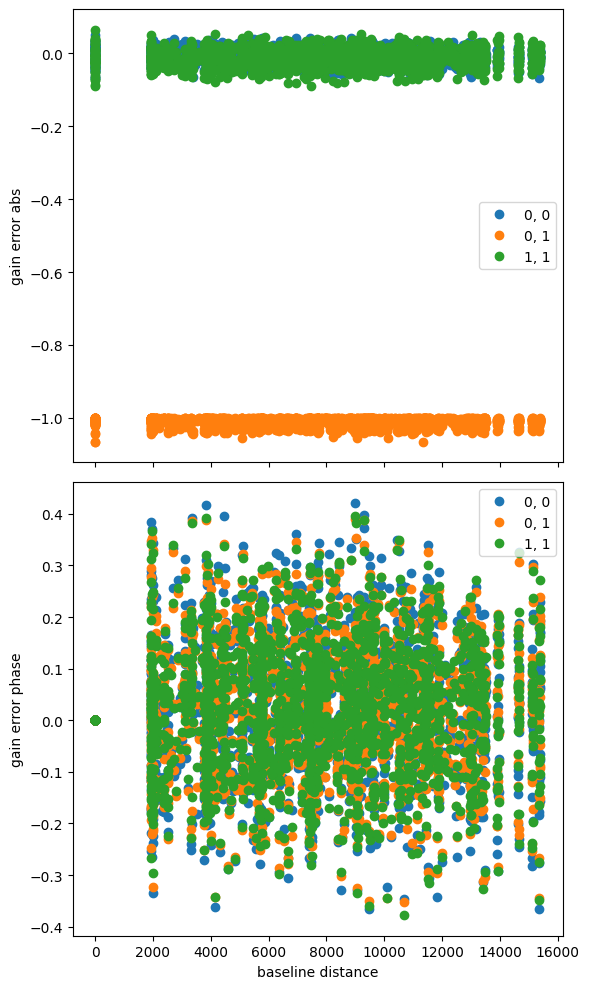

In [24]:
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import jax.lax
import numpy as np
import pylab as plt
from jax import numpy as jnp

from dsa2000_cal.common.noise import calc_baseline_noise
from dsa2000_common.common.quantity_utils import time_to_jnp, quantity_to_jnp
from dsa2000_fm.forward_models.streaming.calibrator import Calibration
from dsa2000_fm.forward_models.utils import ObservationSetup
from dsa2000_common.visibility_model.source_models.celestial.base_point_source_model import build_point_source_model

full_stokes = True
D = 1
T = 1
setup = ObservationSetup.create_tracking_from_array(
    array_name='dsa2000W_small',
    ref_time=at.Time('2021-01-01T00:00:00', scale='utc'),
    num_timesteps=T,
    phase_center=ac.ICRS(ra=20 * au.deg, dec=30 * au.deg)
)
print(setup)
num_ant = len(setup.antennas)
F = len(setup.freqs)

calibration = Calibration(
    full_stokes=full_stokes,
    num_ant=num_ant,
    num_background_source_models=0,
    verbose=True
)
visibility_coords = setup.far_field_delay_engine.compute_visibility_coords(
    freqs=quantity_to_jnp(setup.freqs),
    times=time_to_jnp(setup.obstimes, setup.ref_time),
    with_autocorr=True,
    convention='physical'
)

true_gains = 1 + 0.1j * jax.random.normal(jax.random.PRNGKey(2), (D, T, num_ant, F, 1, 1))
true_gains *= jnp.exp(1j * jnp.pi / 2)

source_models = []
vis_model = []
for d in range(D):
    ra = (20 + 1 * np.random.normal(size=(1,))) * au.deg
    dec = (30 + 1 * np.random.normal(size=(1,))) * au.deg
    point_source_model = build_point_source_model(
        model_freqs=setup.freqs,
        ra=ra,
        dec=dec,
        A=np.ones((1, F, 2, 2)) * au.Jy if full_stokes else np.ones((1, F)) * au.Jy
    )
    source_models.append(point_source_model)
    g1 = true_gains[d][:, visibility_coords.antenna1, :, :, :]  # [T, B, F, 1, 1]
    g2 = true_gains[d][:, visibility_coords.antenna2, :, :, :]  # [T, B, F, 1, 1]
    vis_model.append(
        point_source_model.predict(
            visibility_coords=visibility_coords,
            gain_model=None,
            near_field_delay_engine=setup.near_field_delay_engine,
            far_field_delay_engine=setup.far_field_delay_engine,
            geodesic_model=setup.geodesic_model
        ) * (g1 * jnp.conj(g2))
    )

vis_model = jnp.stack(vis_model, axis=0)
vis_data = jnp.sum(vis_model, axis=0)

B = len(visibility_coords.antenna1)

assert np.shape(vis_data) == (T, B, F, 2, 2)
assert np.shape(vis_model) == (D, T, B, F, 2, 2)
assert np.shape(true_gains) == (D, T, num_ant, F, 1, 1)

noise_scale = calc_baseline_noise(
    system_equivalent_flux_density=5000,
    chan_width_hz=130e3 * 40*4,
    t_int_s=1.5 * 4*4
)
print(noise_scale)
noise_scale /= np.sqrt(2.)

vis_data += noise_scale * jax.lax.complex(
    jax.random.normal(jax.random.PRNGKey(0), vis_data.shape),
    jax.random.normal(jax.random.PRNGKey(1), vis_data.shape)
)
weights = jnp.full(vis_data.shape, 1. / noise_scale ** 2)
flags = jnp.zeros(vis_data.shape, dtype=jnp.bool_)

state = None
gains, vis_data_residuals, state, diagnostics = calibration.step(
    vis_model=vis_model,
    vis_data=vis_data,
    weights=weights,
    flags=flags,
    freqs=visibility_coords.freqs,
    times=visibility_coords.times,
    antenna1=visibility_coords.antenna1,
    antenna2=visibility_coords.antenna2,
    state=state
)
fig, axs = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
mask = diagnostics.damping > 0.
axs[0].plot(diagnostics.iteration[mask], diagnostics.F_norm[mask])
axs[0].set_ylabel('F norm')
axs[1].plot(diagnostics.iteration[mask], diagnostics.error[mask])
axs[1].set_ylabel('error')
axs[-1].set_xlabel('iteration')
plt.show()

# plot error in abo and phase space

baseline_dist = np.linalg.norm(visibility_coords.uvw, axis=-1)  # [T, B]
freq_idx = 0
time_idx = 0
for d in range(D):
    fig, axs = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

    for p_idx, q_idx in [(0, 0), (0, 1), (1, 1)]:
        g1 = gains[d, :, freq_idx, p_idx, q_idx][visibility_coords.antenna1]
        g2 = gains[d, :, freq_idx, p_idx, q_idx][visibility_coords.antenna2]
        g12 = g1 * np.conj(g2)
        g1_true = true_gains[d, time_idx, :, freq_idx, 0, 0][visibility_coords.antenna1]
        g2_true = true_gains[d, time_idx, :, freq_idx, 0, 0][visibility_coords.antenna2]
        g12_true = g1_true * np.conj(g2_true)
        error_abs = np.abs(g12) - np.abs(g12_true)
        error_phase = np.angle(g12) - np.angle(g12_true)

        axs[0].plot(baseline_dist[time_idx], error_abs, 'o',
                    label=f"{p_idx}, {q_idx}")
        axs[1].plot(baseline_dist[time_idx], error_phase, 'o',
                    label=f"{p_idx}, {q_idx}")
    axs[0].legend()
    axs[1].legend()
    axs[0].set_ylabel('gain error abs')
    axs[1].set_ylabel('gain error phase')
    axs[-1].set_xlabel('baseline distance')

    fig.tight_layout()
    plt.show()




In [25]:
g12

Array([0.97657122+2.50266764e-17j, 0.97778728+1.64111207e-02j,
       1.00258127+2.13970686e-02j, ..., 0.99220343-1.97583976e-17j,
       0.98275347+1.12390606e-02j, 0.97352082+1.10770610e-17j],      dtype=complex128)

In [26]:
g12_true

Array([1.00036717+0.j        , 1.00263458+0.11833136j,
       1.00140598+0.05421355j, ..., 1.00026312+0.j        ,
       1.00002057-0.01495292j, 1.00000161+0.j        ], dtype=complex128)

In [27]:
print(true_gains.shape)
print(np.angle(true_gains[0,0,:,0, 0, 0]) - np.angle(true_gains[0,0,:,0, 0, 0])[0])

(1, 1, 62, 20, 1, 1)
[ 0.         -0.117477   -0.05408464 -0.01463521  0.05772361  0.07491762
  0.10707975  0.1595807   0.02826357  0.0197252   0.06075872  0.14834307
 -0.01686897  0.0549871   0.02311201 -0.1187844  -0.06076245  0.26893361
 -0.05513038  0.0553623   0.0392967   0.07141949  0.03588811  0.06289032
  0.03789926  0.10259936 -0.08221993 -0.0553337   0.1532524   0.00499614
 -0.01686015  0.2280222   0.01720958  0.10828296  0.02192901  0.14661883
  0.13669244  0.10523866  0.10256624  0.04224895  0.06697166 -0.07517616
 -0.08373839  0.07832622  0.13619396 -0.02926976 -0.02547683  0.2704198
  0.16514526  0.12314732  0.13110657  0.09988886  0.22272072  0.11211556
  0.11827983  0.15442736 -0.01361553  0.04736686  0.09817505 -0.07382672
  0.00293973  0.01789123]


In [28]:
print(gains.shape)
print(np.angle(gains[0,:,0, 0,0]) - np.angle(gains[0,:,0, 0,0])[0])

(1, 62, 20, 2, 2)
[ 0.         -0.00054013  0.00920236  0.00172473 -0.0022409  -0.00215535
 -0.00233768 -0.00417684  0.00937496 -0.01456563 -0.00166657  0.02240064
 -0.01013325 -0.00666515  0.00389983  0.02236472  0.00834121 -0.00639158
  0.00454008 -0.01965923 -0.01291306  0.0217826  -0.00245314 -0.02151138
  0.00979534  0.00117513  0.00845149 -0.00226782 -0.02577084  0.00504487
  0.00294018 -0.01523496  0.01274116  0.02099441  0.00089453 -0.032451
 -0.01706187 -0.0100804  -0.01544371 -0.00591987  0.00415162 -0.0273951
 -0.01284113  0.02459605 -0.00822891  0.00195244 -0.01674273 -0.00974748
 -0.01622653  0.00829376 -0.01484973 -0.00570007 -0.03301739 -0.01059941
 -0.00305364 -0.00369551 -0.00155189  0.01324745  0.01285819  0.01242388
  0.00029685  0.02080764]
